In [1]:
import glob
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import path, colors
import skimage.io as io
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta

In [2]:
from caribbean_map import *
from beachings import *

In [3]:
ds = xr.open_dataset('../data/output/cm_mpw/cm_mpw_2013-01-01.nc')  # to have particles from outside the region entering
lon = ds.lon.values
lat = ds.lat.values
nb_traj, nb_obs = lon.shape
origin_date = datetime(2013,1,1)

In [4]:
# distance at each timestep for each trajectory
d = haversine(lon, lat)

In [15]:
threshold_distance = 100*1000 # [m]
period = 30 # [days]
beached_days = 90  # [days]

b_idx = np.zeros(nb_traj, dtype=int)
for i in range(0, nb_traj):
    b_idx[i] = identify_beaching_c1(d[i], threshold_distance, period)

In [13]:
def trajectories(ax, t0, length):
    # smaller length at initial time
    if length > t0:
        length = t0
    
    time_r = range(t0-length, t0+1)
    keep = np.any(~np.isnan(lon[:, time_r]), 1)
    traj = list(zip(lon[keep][:,time_r], lat[keep][:,time_r]))
    
    s, v = [], []
    for x,y in traj:
        pts = np.array([x, y]).T.reshape(-1, 1, 2)
        s.extend(np.concatenate([pts[:-1], pts[1:]], axis=1))
        v.extend(np.arange(0, len(x))/len(x))
    
    v = np.array(v).flatten()
    
    lc = LineCollection(s, cmap=cmocean.cm.ice_r, transform=ccrs.PlateCarree(), alpha=1.0)
    lc.set_array(v) # color per segments/lines
    lc.set_linewidth(0.25) # size of lines
    ax.add_collection(lc)
    
    # add tip
    ax.scatter(lon[keep][:,t0], lat[keep][:,t0], s=0.2, linewidth=0.5, c='k', marker='o', facecolors='fill', zorder=2)
    
    # add red tip if beached
    beached = np.logical_and.reduce((b_idx > -99999, b_idx < t0, b_idx+beached_days >= t0, keep))
    ax.scatter(lon[beached][:,t0], lat[beached][:,t0], s=0.1, linewidth=0.5, c='r', marker='o', facecolors='fill', zorder=2)
    
    return s, v

CPU times: user 4.19 s, sys: 397 ms, total: 4.58 s
Wall time: 4.6 s


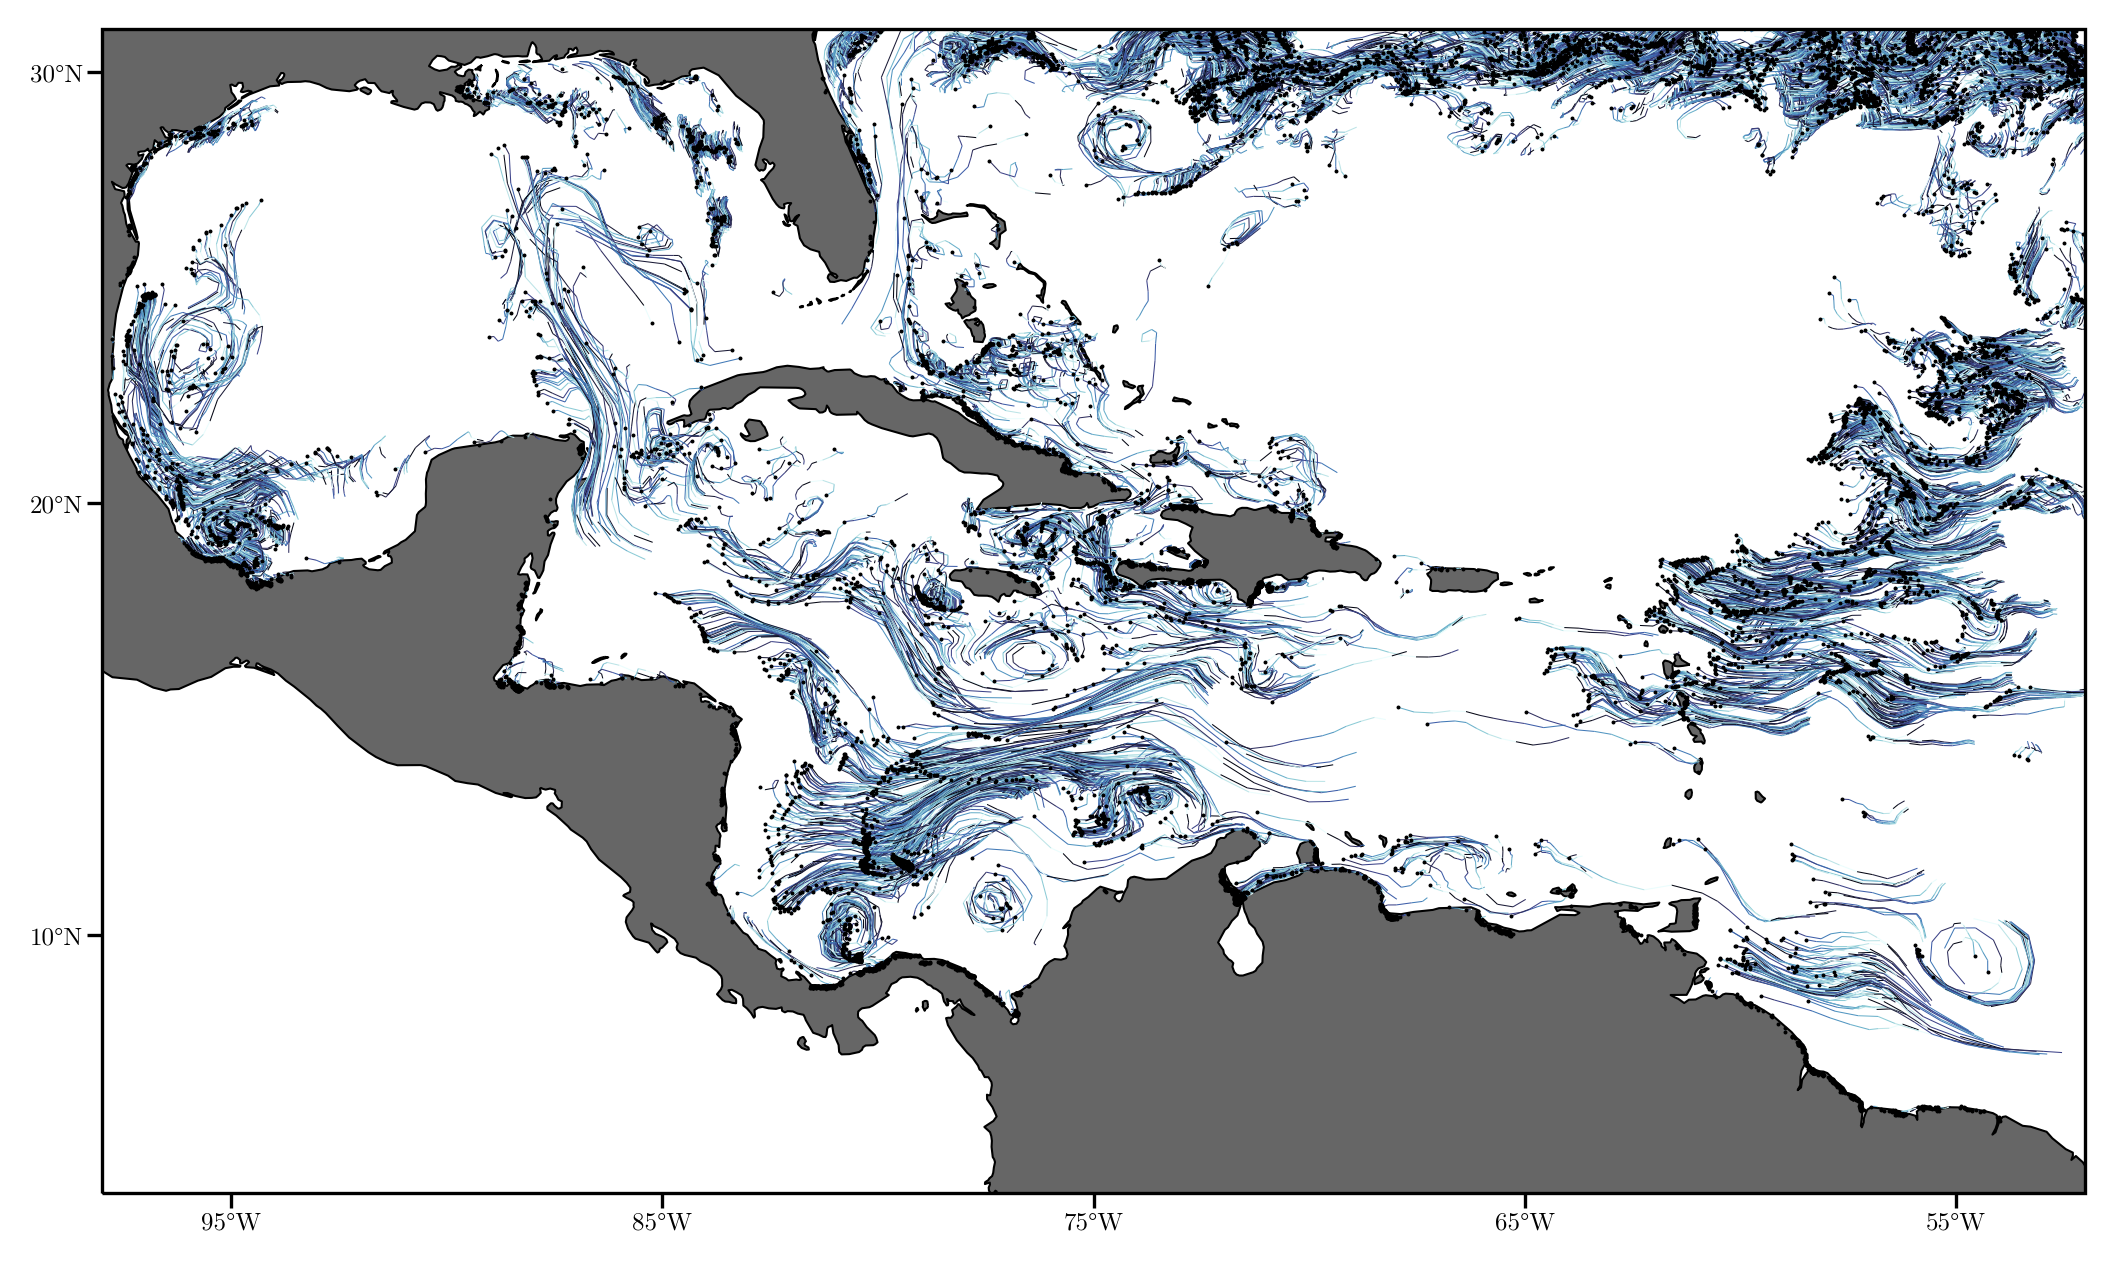

In [14]:
%%time
fig = plt.figure(dpi=300, figsize=fs)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

t0 = 50
traj_length = 10  # index/days because daily output
s, v = trajectories(ax, t0, traj_length)

geo_map(ax)
#ax.set_title(f"Nested Caribbean model {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")
#fig.savefig(f'figures/cm_mpw_{t0:04d}.png', format='png', dpi=600)

-99999
-99999
[40]


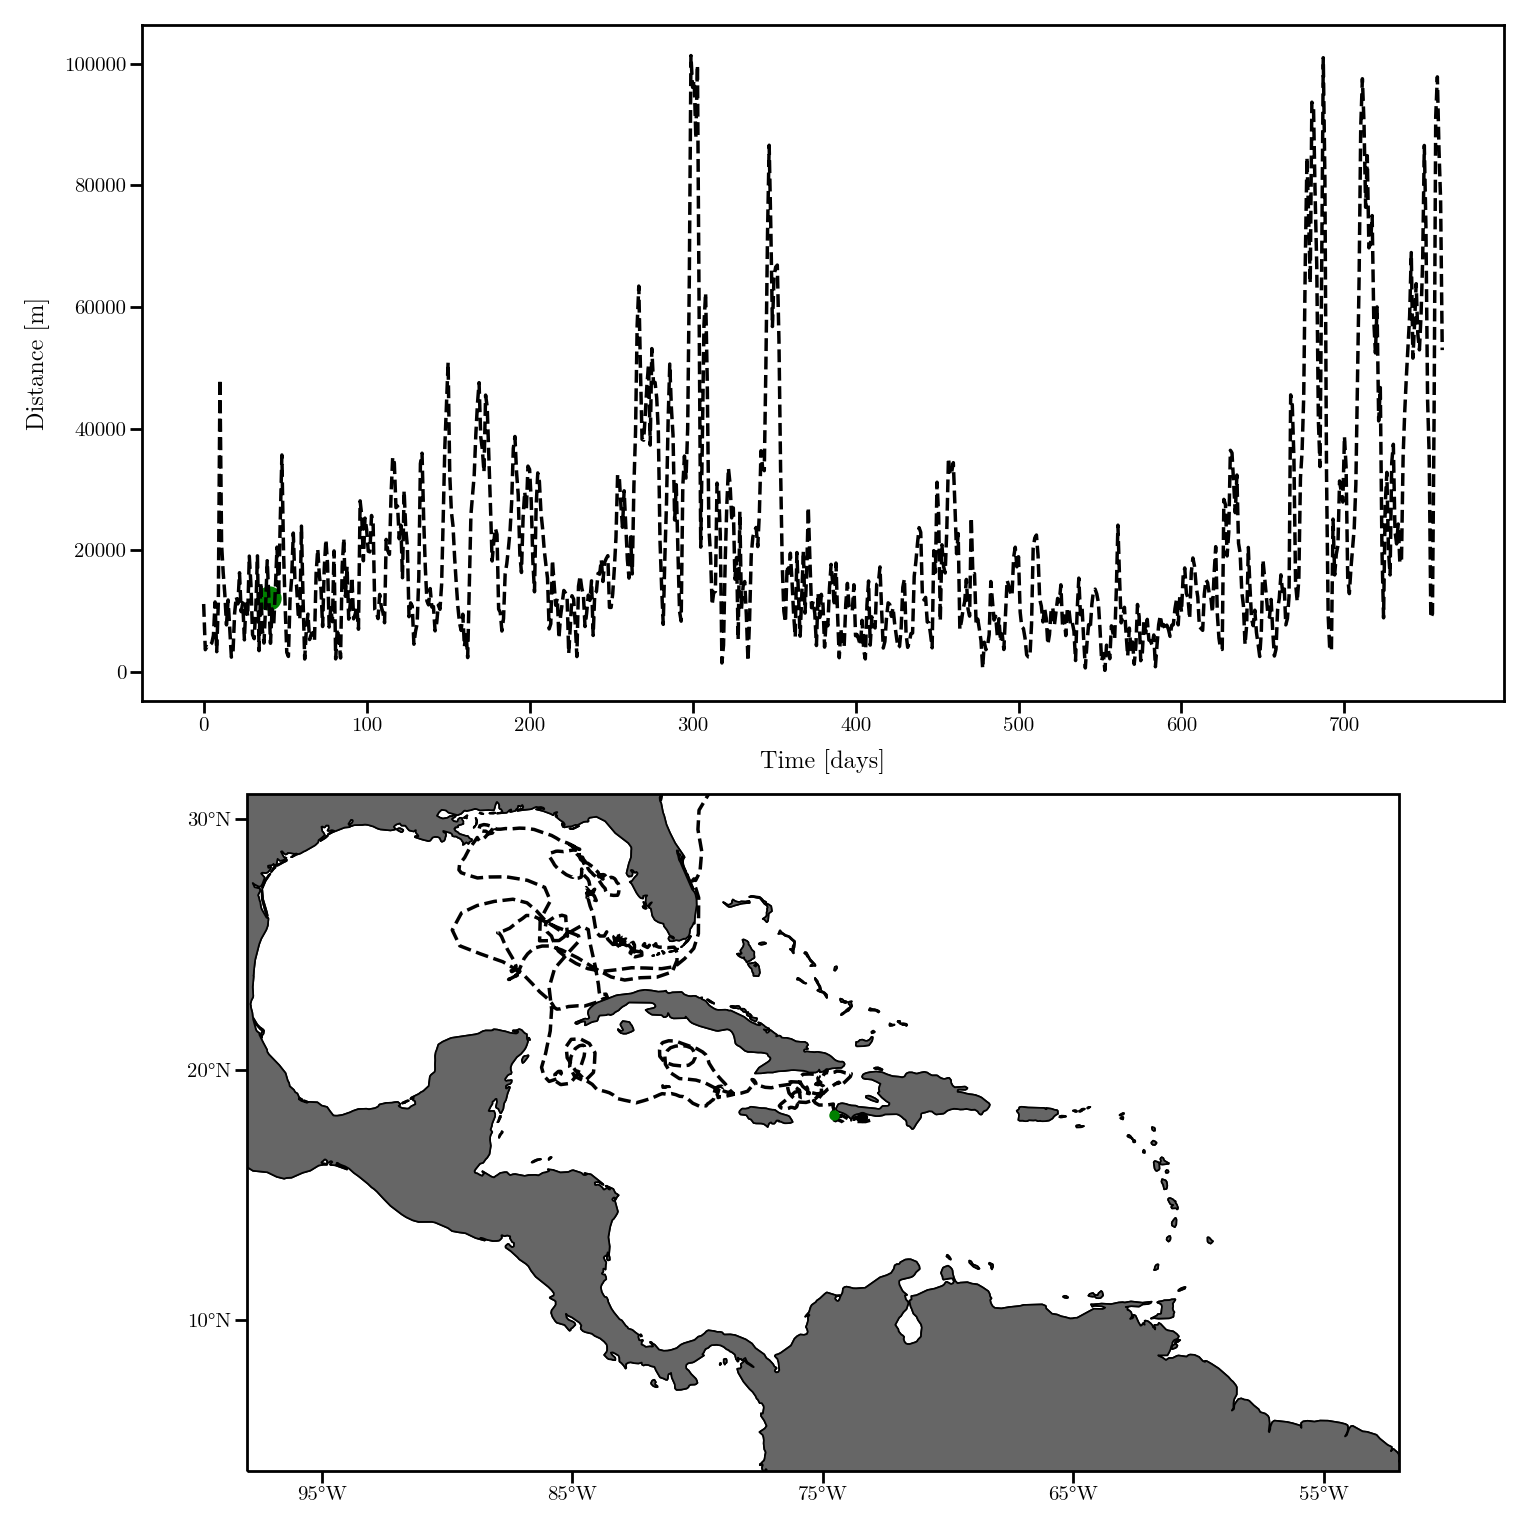

In [5]:
i = 5405
fig = plt.figure(dpi=250, figsize=(6,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree(), aspect='equal')


ax1.plot(d[i,:], c='black', lw=1, ls='dashed')
ax2.plot(lon[i,:], lat[i,:], c='black', lw=1, ls='dashed')
ax2.scatter(lon[i, 0], lat[i, 0], s=5, c='black', zorder=2)

# Criteria 1
# Less than 100km in the past 30 days
period = 30 # [days]
threshold_distance = 100*1000 # [m]
c1 = identify_beaching_c1(d[i], threshold_distance, period)

if c1 != -99999:
    ax1.scatter(c1, d[i, c1], c='red')
    ax2.scatter(lon[i, c1], lat[i, c1], s=4, c='red', zorder=2)
    ax1.set_xlim([0, c1+100])

# Criteria 2
# Less than 3km per day for 30 consecutive days
threshold_distance = 3000 # [m]
period = 30  # [days]
c2 = identify_beaching_c2(d[i], threshold_distance, period)
if c2 != -99999:
    ax1.scatter(c2, d[i, c2], c='blue')
    ax2.scatter(lon[i, c2], lat[i, c2], s=4, c='blue', zorder=2)

ax1.set_xlabel('Time [days]')
ax1.set_ylabel('Distance [m]')  
geo_map(ax2)

# Criteria 3
# Beaching probability when close to the coast
threshold_distance = -8  # km 
probability = 1-0.5**(1/5)
delay = 30  # days
c3 = identify_beaching_c3(np.expand_dims(d[i], axis=0), probability, threshold_distance, delay)

if c3 != -99999:
    ax1.scatter(c3, d[i, c3], c='green')
    ax2.scatter(lon[i, c3], lat[i, c3], s=4, c='green', zorder=2)

ax1.set_xlabel('Time [days]')
ax1.set_ylabel('Distance [m]') 
geo_map(ax2)

#b_idx = np.zeros(nb_traj, dtype=int)
#for i in range(0, nb_traj):
#    b_idx[i] = identify_beaching(d[i], threshold_distance, period)

print(c1)
print(c2)
print(c3)

In [10]:
caribbean_countries = [ 
    # caribbean countries
    'Antigua and Barbuda', 'Bahamas', 'Barbados',
    'Cuba', 'Dominica', 'Dominican Republic',
    'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Trinidad and Tobago',
    # dependant teritory
    'Anguilla', 'Aruba',
    'Bonaire, Sint Eustatius and Saba',
    'British Virgin Islands', 'Cayman Islands',
    'Curaçao', 'Guadeloupe', 'Martinique',
    'Montserrat', 'Puerto Rico', 'Saint-Barthélemy',
    'Saint-Martin', 'Sint Maarten',
    'Turks and Caicos Islands', 'Virgin Islands, U.S.',
    # nearby countries
    'Mexico', 'United States', 'Venezuela', 'Belize', 'Colombia',
    'Costa Rica', 'Guatemala', 'Guyana', 'Honduras', 'Nicaragua', 'Panama',
    'Suriname',
    # needed to split the coastlines of USA properly (not part of the output!)
    'Canada',
    ]

In [17]:
# chose 3 countries as example
cids = [0, 10, 12]
for c_id in cids:
    print(caribbean_countries[c_id])

Antigua and Barbuda
Saint Lucia
Trinidad and Tobago


In [ ]:
for c_id in cids:
    # get id of country trajectories
    traj_index = np.where(df['country id'] == c_id)[0]
    nb_traj = len(traj_index) * len(files)
    lon = np.full((nb_traj, nb_obs), np.nan)
    lat = np.full((nb_traj, nb_obs), np.nan)
    
    # loop the files to read all trajectories
    for i, f in enumerate(files):
        r = slice(i*len(traj_index), (i+1)*len(traj_index))    
        ds = xr.open_dataset(f)
        offset = nb_obs - ds.dims['obs']
        lon[r, offset:] = ds.lon[traj_index]
        lat[r, offset:] = ds.lat[traj_index]
        ds.close()
        
    # beaching critera
    # distance at each timestep for each trajectory
    d = haversine(lon, lat)

    # identify beaching
    # a drifters is considered beach if it travels less than 3km for 30 days in a row
    # which is similar to the < 100km in the past month Xiaobiao used
    threshold_distance = 3000 # [m]
    period = 30 # [days]
    beached_days = 90  # [days]
    
    b_idx = np.zeros(nb_traj, dtype=int)
    b_time = np.zeros(nb_traj, dtype='datetime64[ns]')
    for i in range(0, nb_traj):
        b_idx[i] = identify_beaching(d[i], threshold_distance, period)

    # replace values after beaching with previous value to stop particles
    for i in np.where(b_idx != -99999)[0]:
        j = b_idx[i]
        lon[i,j+1:] = np.nan
        lat[i,j+1:] = np.nan
        lon[i,j+1:j+1+beached_days] = lon[i,j]
        lat[i,j+1:j+1+beached_days] = lat[i,j]
    
    # create the frames
    for t0 in range(0, nb_obs):
        fig = plt.figure(dpi=100)
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

        traj_length = 10  # index/days because daily output
        s, v = trajectories(ax, t0, traj_length)

        geo_map(ax)
        ax.set_title(f"{caribbean_countries[c_id]} {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")
        fig.savefig(f'countries/cm_uniform_{c_id}_{t0:04d}.png', bbox_inches='tight', format='png', dpi=300)
        plt.close(fig)